```
# Copyright 2023 by the author(s) of CHI2023 Late Breaking Work
# "Exploring Physiological Correlates of Visual Complexity Adaptation:
# Insights from EDA, ECG, and EEG Data for Adaptation Evaluation in VR
# Adaptive Systems". All rights reserved.
#
# Use of this source code is governed by a GPLv3 license that
# can be found in the LICENSE file.
```

In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

from lbw import get_event_intervals

In [2]:
def load_ecg(pid):

    dfECG = pd.read_csv(f"./data/ID{pid}-ECG.csv")
    dfState = pd.read_csv(f"./data/ID{pid}-state.csv")
    dfAdaptation = pd.read_csv(f"./data/ID{pid}-adaptation.csv")
    dfECG.drop("TimeLsl", axis =1, inplace=True)

    intervals, workloads = get_event_intervals(dfAdaptation)
    for idx, interval in enumerate(intervals):
        dfECG.loc[(dfECG['Time'] >= interval[0]) & (dfECG['Time'] <= interval[1]), 'workload'] = workloads[idx]
        dfECG.loc[(dfECG['Time'] >= interval[0]) & (dfECG['Time'] <= interval[1]), 'interval_id'] = idx
    dfECG = dfECG[dfECG['workload'].notna()]

    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][2]) & (dfECG.Time < dfState['Time'][2+1])].index, 'BlockNumber']   = dfState['BlockNumber'][2]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][4]) & (dfECG.Time < dfState['Time'][4+1])].index, 'BlockNumber']   = dfState['BlockNumber'][4]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][6]) & (dfECG.Time < dfState['Time'][6+1])].index, 'BlockNumber']   = dfState['BlockNumber'][6]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][8]) & (dfECG.Time < dfState['Time'][8+1])].index, 'BlockNumber']  = dfState['BlockNumber'][8]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][10]) & (dfECG.Time < dfState['Time'][10+1])].index, 'BlockNumber'] = dfState['BlockNumber'][10]
    dfECG.loc[dfECG[(dfECG.Time > dfState['Time'][12]) & (dfECG.Time < dfState['Time'][12+1])].index, 'BlockNumber'] = dfState['BlockNumber'][12]
    dfECG = dfECG.dropna()
    dfECG = dfECG.sort_values(by="Time")
    return dfECG

def extract_ecg_features(pid, df):
    df_features = pd.DataFrame()
    intervals = df.interval_id.unique()
    for interval_id in intervals:
        df_current = df[df.interval_id == interval_id]

        if len(df_current['Value']) < 230:
            df_features = df_features.append(pd.DataFrame.from_dict([{
                'pid': pid,
                'workload': df_current['workload'].iloc[0],
                'interval': interval_id,
            }]))
            continue

        # # H10 Technical Specification
        # # Sample rate = 130 Hz ± 2 % (Tamb = +20 … +40 °C)
        # #               130 Hz ± 5 % (Tamb = -20 … +70 °C)
        # # https://github.com/polarofficial/polar-ble-sdk/blob/master/technical_documentation/H10_ECG_Explained.docx
        s, _ = nk.ecg_process(df_current['Value'], sampling_rate=130)
        peaks, _ = nk.ecg_peaks(nk.ecg_clean(df_current['Value'], sampling_rate=130),
                                sampling_rate=130,
                                correct_artifacts=True)

        try:
            hrv_rmssd = np.mean(nk.hrv(peaks, sampling_rate=130)['HRV_RMSSD'])
        except Exception:
            hrv_rmssd = np.NaN


        df_features = df_features.append(pd.DataFrame.from_dict([{
            'pid': pid,
            'workload': df_current['workload'].iloc[0],
            'interval': interval_id,
            # https://neuropsychology.github.io/NeuroKit/functions/ecg.html?highlight=ecg_rate
            'ecg_rate_mean': np.mean(s['ECG_Rate']),
            'ecg_rate_var': np.var(s['ECG_Rate']),
            # https://neuropsychology.github.io/NeuroKit/examples/ecg_hrv/ecg_hrv.html?highlight=rmssd
            'hrv_rmssd': hrv_rmssd,
        }]))
    return df_features

In [3]:
pid_valid = [4, 5, 7, 9, 10, 11, 12, 13]
df_all = {}

for pid in tqdm.tqdm(pid_valid):
    df = load_ecg(pid)
    df_all[pid] = df

100%|██████████| 8/8 [00:01<00:00,  5.22it/s]


In [4]:
df = pd.DataFrame()
for pid in pid_valid:
    df_features = extract_ecg_features(pid, df_all[pid])
    df = df.append(df_features)
df

,pid,workload,interval,ecg_rate_mean,ecg_rate_var,hrv_rmssd
0,4,low,0.0,101.691743,768.889866,305.385272
0,4,high,1.0,82.268868,561.024381,378.258504
0,5,low,0.0,81.405105,666.763541,363.035634
0,5,high,1.0,84.830229,720.261262,387.400175
0,5,low,2.0,101.942719,1248.513926,317.491622
...,...,...,...,...,...,...
0,13,low,10.0,88.520034,903.015398,392.783097
0,13,high,11.0,102.132568,1149.148648,320.594861
0,13,low,12.0,95.792852,825.593806,239.975514
0,13,high,13.0,113.298078,242.748618,72.813290


In [5]:
df.to_csv("./processed/ecg.csv", index=False)

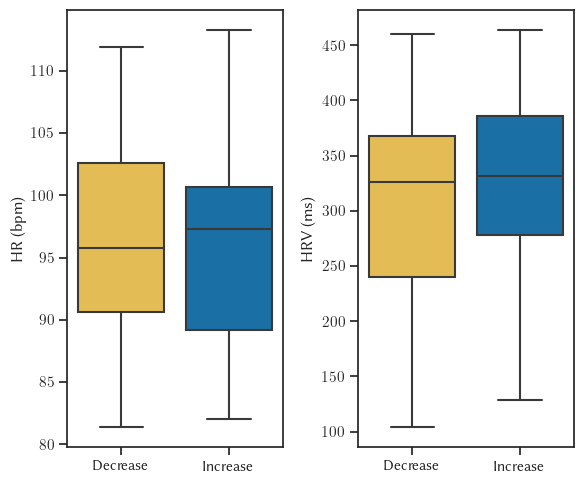

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))
colors = list({'yellow' : '#FBC63D', 'blue': '#0376BB'}.values())
sns.boxplot(x='workload', y='ecg_rate_mean', data=df, ax=axes[0], palette=colors, showfliers=False)
sns.boxplot(x='workload', y='hrv_rmssd', data=df, ax=axes[1], palette=colors, showfliers=False)

axes[0].set_ylabel('HR (bpm)')
axes[1].set_ylabel('HRV (ms)')

axes[0].set_xticklabels(['Decrease', 'Increase'])
axes[1].set_xticklabels(['Decrease', 'Increase'])

axes[0].set_xlabel('')
axes[1].set_xlabel('')

plt.tight_layout()
plt.savefig('figures/fig1ecg.pdf')